In [555]:
import sys; sys.path.append('..')
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

from src.utils.metrics import (
    compute_average_accuracy,
    compute_forgetting_measure,
    compute_learning_curve_area,
    compute_ausuc,
    compute_ausuc_matrix,
    compute_individual_accs_matrix,
    compute_task_transfer_matrix,
    compute_seen_classes_acc_history,
    compute_unseen_classes_acc_history,
    compute_joined_ausuc_history,
    compute_acc_for_classes
)


def compute_average_taskwise_accucy(logits_history, targets, class_splits):
    assert len(logits_history) == len(class_splits) + 1
    
    acc_matrix = compute_individual_accs_matrix(logits_history[1:], targets, class_splits)
    acc_matrix = np.tril(acc_matrix)
    accs = acc_matrix.sum(axis=1) / np.arange(1, len(class_splits) + 1)
    
    return accs

In [569]:
import collections
from typing import Dict, List

from firelab.config import Config
import pandas as pd
from tqdm import tqdm

def get_exp_args(config: Config):
    short_name_to_name = {
#         'protos': 'hp.head.num_prototypes',
#         'protos_test': 'hp.head.num_test_prototypes',
#         'noise_transform': 'hp.head.noise.transform_layers',
#         'std': 'hp.head.noise.std',
#         'attrs_transform': 'hp.head.attrs_transform_layers',
#         'final_transform': 'hp.head.after_fuse_transform_layers',
#         'fusing_type': 'hp.head.fusing_type',
#         'same_noise_for_each_class': 'hp.head.noise.same_for_each_class',
#         'protos': 'hp.head.num_prototypes',
#         'protos-test': 'hp.head.num_test_prototypes',
#         'n_epochs': 'hp.max_num_epochs',
#         'std': 'hp.head.noise.std',
#         'lr': 'hp.optim.kwargs.lr',
#         'batch_size': 'hp.batch_size',
#         'optim': 'hp.optim.type',
#         'scale_value': 'hp.head.scale_value',
#         'minus_distance': 'hp.head.use_final_activation'
        'type': 'hp.head.type',
        'scale.type': 'hp.head.scale.type',
        'momentum': 'hp.optim.kwargs.momentum',
        'optim': 'hp.optim.type',
        #'seed': 'random_seed',
    }
    
    return {short_name: config.get(name) for short_name, name in short_name_to_name.items()}


def get_exp_shortname(config: Config):
    return ' '.join([f'[{k}: {v}]' for k, v in get_exp_args(config).items()])


def find_exps(experiments_dir: os.PathLike) -> Dict[str, List[str]]:
    """
    Returns dictionary, where a key is a shortname of the experiment
    and the value is the list of different runs (grouped by shortname)
    """
    experiments_dirs = [os.path.join(experiments_dir, e) for e in os.listdir(experiments_dir)]
    configs = [Config.load(os.path.join(e, 'config.yml')) for e in tqdm(experiments_dirs, desc='Loading configs')]
    shortnames = [get_exp_shortname(c) for c in configs]
    
    result = collections.defaultdict(list)
    for e, name in zip(experiments_dirs, shortnames):
        result[name].append(e)

    return dict(result)

In [570]:
dataset = 'CUB'
tasks = np.arange(1, 11)
# experiments_dir = '/ibex/scratch/skoroki/experiments/multi_proto_random_optim_small_noise'
# experiments_dir = '/ibex/scratch/skoroki/experiments/multi_proto_random_optim'
experiments_dir = '../experiments'

exps = find_exps(experiments_dir)
exps = {m: [e for e in exps[m] if os.path.exists(f'{e}/custom_data/logits_history.npy')] for m in exps}
exps = {m: [e for e in exps[m] if os.path.exists(f'{e}/custom_data/targets.npy')] for m in exps}
exps = {m: [e for e in exps[m] if os.path.exists(f'{e}/custom_data/class_splits.npy')] for m in exps}
exps = {m: exps[m] for m in exps if len(exps[m]) > 0}
methods = list(exps.keys())

logits_histories = {m: [np.load(f'{e}/custom_data/logits_history.npy') for e in exps[m]] for m in tqdm(exps, desc='Loading logits histories')}
targets = {m: [np.load(f'{e}/custom_data/targets.npy') for e in exps[m]] for m in tqdm(exps, desc='Loading targets')}
class_splits = {m: [np.load(f'{e}/custom_data/class_splits.npy', allow_pickle=True) for e in exps[m]] for m in tqdm(exps, desc='Loading class splits')}
configs = {m: [Config.load(f'{e}/config.yml') for e in exps[m]] for m in tqdm(exps, desc='Loading configs')}

Loading configs: 100%|██████████| 7/7 [00:00<00:00, 85.86it/s]


In [571]:
def plot_unseen_acc(methods, restrict_space: bool=False):
    plt.figure(figsize=(15, 7))
    plt.title(f'Accuracy on unseen for {dataset} (space restriction: {restrict_space})')

    for method in methods:
        values = [compute_unseen_classes_acc_history(l[:-1], t, c, restrict_space=restrict_space) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
        values_avg = np.array(values).mean(0) * 100
        #kwargs = {'lineStyle': '--'} if 'true' in method else {}
        kwargs = {}
        plt.plot(tasks, values_avg, label=f'{method} (final: {values_avg[-1]: .3f})', **kwargs)

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True)
    # plt.legend()
    plt.xlabel('Task')
    plt.ylabel('Accuracy on unseen classes')
    plt.xticks(tasks)
    plt.grid()


def plot_seen_acc(methods, restrict_space: bool=False):
    plt.figure(figsize=(15, 7))
    plt.title(f'Accuracy on seen for {dataset} (space restriction: {restrict_space})')

    for method in methods:
        values = [compute_seen_classes_acc_history(l[1:], t, c, restrict_space=restrict_space) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
        values_avg = np.array(values).mean(0) * 100
        #kwargs = {'lineStyle': '--'} if 'true' in method else {}
        kwargs = {}
        plt.plot(tasks, values_avg, label=f'{method} (final: {values_avg[-1]: .3f})', **kwargs)

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True)
    #plt.legend()
    plt.xlabel('Task')
    plt.ylabel('Accuracy on seen classes')
    plt.xticks(tasks)
    plt.grid()
    
    
def get_exps_for_a_group(exps, configs, group):
    result = {}
    
    for exp_shortname, exp_paths in exps.items():
        config = configs[exp_shortname][0]
        
        if all(config.get(k) == v for k, v in group.items()):
            result[exp_shortname] = exp_paths
            
    return result

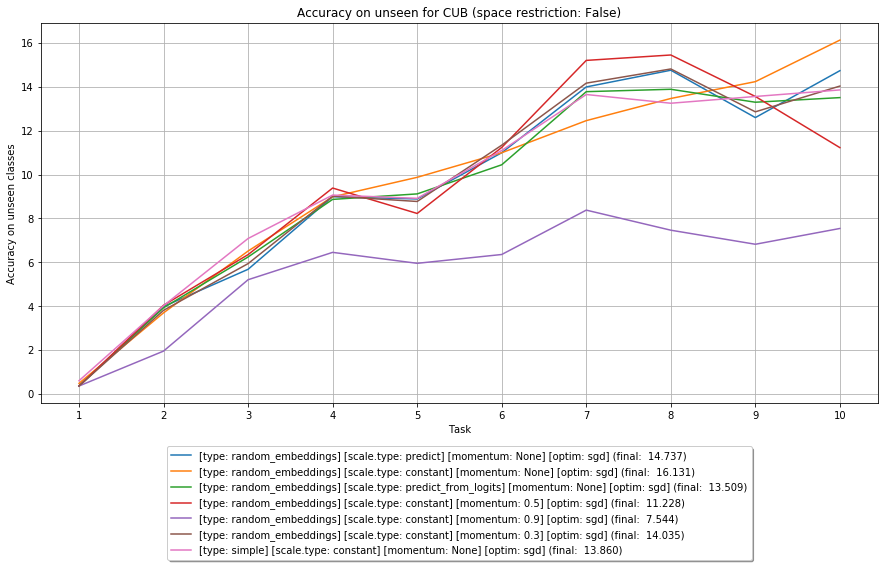

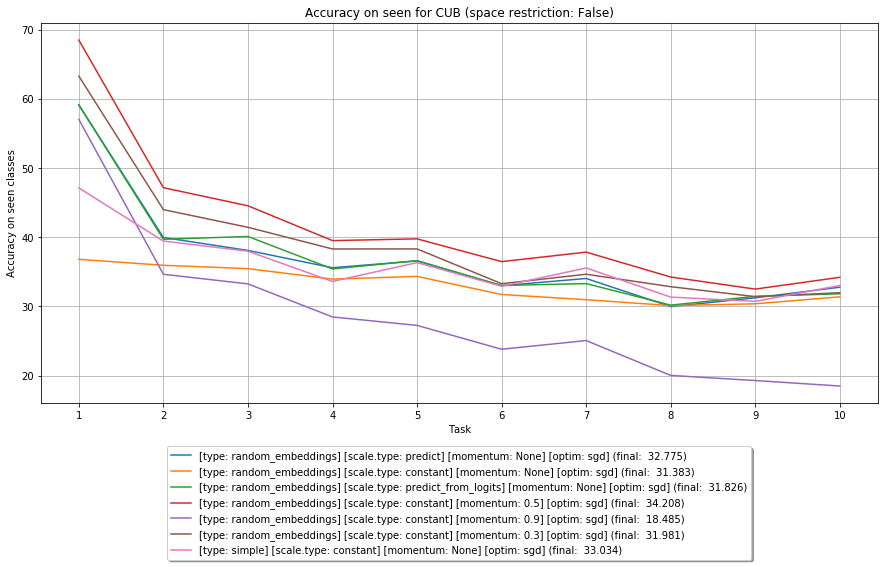

In [572]:
groups = [{}]

for group in groups:
    methods = get_exps_for_a_group(exps, configs, group)
    #methods = {**get_exps_for_a_group(exps, configs, baseline_group), **methods}
    plot_unseen_acc(methods)
    plot_seen_acc(methods)
    #plot_unseen_acc(methods, True)
    #plot_seen_acc(methods, True)

In [489]:
from typing import Tuple

def compute_mean_accs(method: str, restrict_space: bool) -> Tuple[float, float]:
    unseen_accs = [compute_unseen_classes_acc_history(l[:-1], t, c, restrict_space=restrict_space) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    seen_accs = [compute_seen_classes_acc_history(l[1:], t, c, restrict_space=restrict_space) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    
    unseen_accs_avg = np.array(unseen_accs).mean(0) * 100
    seen_accs_avg = np.array(seen_accs).mean(0) * 100
    
    return unseen_accs_avg, seen_accs_avg

unseen_accs_non_restrict, seen_accs_non_restrict = zip(*[compute_mean_accs(m, False) for m in tqdm(methods, desc='Computing mean accs')])
unseen_accs_restrict, seen_accs_restrict = zip(*[compute_mean_accs(m, True) for m in tqdm(methods, desc='Computing mean accs')])

Computing mean accs: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


In [490]:
harmonic_accs_non_restrict = [2 * u * s / (u + s) for u, s in zip(unseen_accs_non_restrict, seen_accs_non_restrict)]
harmonic_accs_restrict = [2 * u * s / (u + s) for u, s in zip(unseen_accs_restrict, seen_accs_restrict)]

In [491]:
mean_unseen_accs_non_restrict = [a.mean() for a in unseen_accs_non_restrict]
mean_unseen_accs_restrict = [a.mean() for a in unseen_accs_restrict]
mean_seen_accs_non_restrict = [a.mean() for a in seen_accs_non_restrict]
mean_seen_accs_restrict = [a.mean() for a in seen_accs_restrict]
mean_harmonic_accs_non_restrict = [a.mean() for a in harmonic_accs_non_restrict]
mean_harmonic_accs_restrict = [a.mean() for a in seen_accs_restrict]

final_unseen_accs_non_restrict = [a[-1] for a in unseen_accs_non_restrict]
final_unseen_accs_restrict = [a[-1] for a in unseen_accs_restrict]
final_seen_accs_non_restrict = [a[-1] for a in seen_accs_non_restrict]
final_seen_accs_restrict = [a[-1] for a in seen_accs_restrict]
final_harmonic_accs_non_restrict = [a[-1] for a in harmonic_accs_non_restrict]
final_harmonic_accs_restrict = [a[-1] for a in harmonic_accs_restrict]

In [470]:
def print_top_methods(accs, title: str, n_top: int=5):
    print(f'Top-{n_top} methods for {title}: ')
    for rank, i in enumerate(np.argsort(accs)[::-1][:n_top]):
        print(f'{rank+1}. {accs[i]:.03f} =>', methods[i])
        
    print('\n<==========================================================================================>\n')
        
print_top_methods(mean_unseen_accs_non_restrict, 'mean unseen')
print_top_methods(mean_unseen_accs_restrict, 'mean unseen [restrict space]')

print_top_methods(final_unseen_accs_non_restrict, 'final unseen')
print_top_methods(final_unseen_accs_restrict, 'final unseen [restrict space]')

print_top_methods(mean_seen_accs_non_restrict, 'mean seen')
print_top_methods(mean_seen_accs_restrict, 'mean seen [restrict space]')

print_top_methods(final_seen_accs_non_restrict, 'final seen')
print_top_methods(final_seen_accs_restrict, 'final seen [restrict space]')

print_top_methods(mean_harmonic_accs_non_restrict, 'mean harmonic')
print_top_methods(mean_harmonic_accs_restrict, 'mean harmonic [restrict space]')

print_top_methods(final_harmonic_accs_non_restrict, 'final harmonic')
print_top_methods(final_harmonic_accs_restrict, 'final harmonic [restrict space]')

Top-5 methods for mean unseen: 
1. 10.851 => [protos: 10] [protos-test: 100] [n_epochs: 10] [std: 0.1] [lr: 0.003] [batch_size: 10] [optim: sgd]
2. 10.827 => [protos: 10] [protos-test: 25] [n_epochs: 10] [std: 0.1] [lr: 0.003] [batch_size: 10] [optim: sgd]
3. 10.785 => [protos: 25] [protos-test: 100] [n_epochs: 10] [std: 0.1] [lr: 0.003] [batch_size: 10] [optim: sgd]
4. 10.729 => [protos: 25] [protos-test: 25] [n_epochs: 10] [std: 0.1] [lr: 0.003] [batch_size: 10] [optim: sgd]
5. 10.724 => [protos: 1] [protos-test: 1] [n_epochs: 10] [std: 0.0] [lr: 0.003] [batch_size: 10] [optim: sgd]

<==========================================================================================>

Top-5 methods for mean unseen [restrict space]: 
1. 27.075 => [protos: 1] [protos-test: 1] [n_epochs: 5] [std: 0.0] [lr: 0.01] [batch_size: 10] [optim: sgd]
2. 26.699 => [protos: 1] [protos-test: 1] [n_epochs: 10] [std: 0.0] [lr: 0.003] [batch_size: 10] [optim: sgd]
3. 26.569 => [protos: 1] [protos-test: 1] [n_e

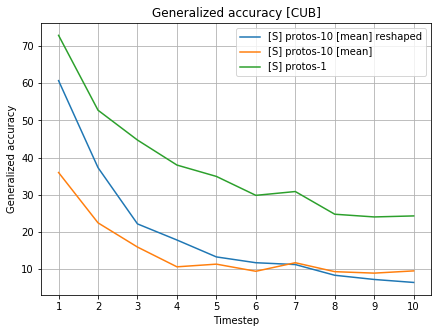

In [114]:
from matplotlib.colors import BASE_COLORS

# colors = list(BASE_COLORS.keys())
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(7, 5))
plt.title(f'Generalized accuracy [{dataset}]')

for i, method in enumerate(methods):
    values = [compute_seen_classes_acc_history(l[1:], t, c) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    values_avg = np.array(values).mean(0)
#     if '(1/4)' in method:
#         kwargs = {"marker": "*"}
#     elif '(1/2)' in method:
#         kwargs = {"marker": ".", 'markersize': 7}
    if 'DEM' in method:
        kwargs = {"marker": ".", 'markersize': 7}
    else:
        kwargs = {}
        
    if 'no' in method:
        kwargs = {**kwargs, **{'linestyle': '-.'}}
    #plt.plot(tasks, values_avg * 100, label=fr'[S] {method} (final: {values_avg[-1] * 100: .3f})', color=colors[i % len(colors)], **kwargs)
    plt.plot(tasks, values_avg * 100, label=fr'[S] {method}', color=colors[i % len(colors)], **kwargs)

plt.legend()
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True)
plt.xlabel('Timestep')
plt.ylabel('Generalized accuracy')
plt.xticks(tasks)
plt.grid()

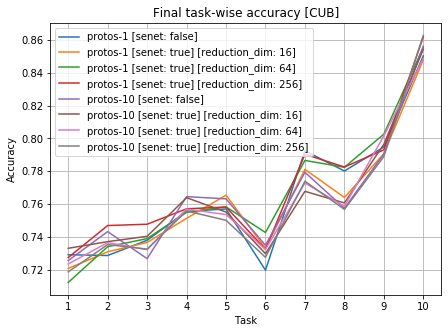

In [60]:
plt.figure(figsize=(7, 5))
plt.title(f'Final task-wise accuracy [{dataset}]')

for method in methods:
    values = [[compute_acc_for_classes(l[-1], t, cs) for cs in c] for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    values_avg = np.array(values).mean(0)
    
    if 'DEM' in method:
        kwargs = {"marker": ".", 'markersize': 7}
    else:
        kwargs = {}
        
    #plt.plot(tasks, values_avg, label=f'{method} (mean: {values_avg.mean(): .3f})', **kwargs)
    plt.plot(tasks, values_avg, label=f'{method}', **kwargs)

# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True)
plt.legend()
plt.xlabel('Task')
plt.ylabel('Accuracy')
plt.xticks(tasks)
plt.grid()
# plt.savefig(f'../plots/{dataset.lower()}-final-accs.pdf')

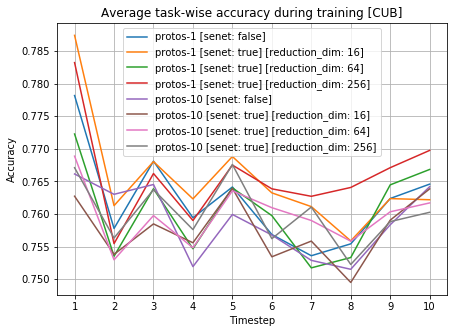

In [61]:
plt.figure(figsize=(7, 5))
plt.title(f'Average task-wise accuracy during training [{dataset}]')

for method in methods:
    values = [compute_average_taskwise_accucy(l, t, c) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    values_avg = np.array(values).mean(0)
        
    #plt.plot(tasks, values_avg, label=f'{method} (final: {values_avg[-1]: .3f})', **kwargs)
    plt.plot(tasks, values_avg, label=f'{method}')

# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True)
plt.legend()
plt.xlabel('Timestep')
plt.ylabel('Accuracy')
plt.xticks(tasks)
plt.grid()
# plt.savefig(f'../plots/{dataset.lower()}-average-acc.pdf')

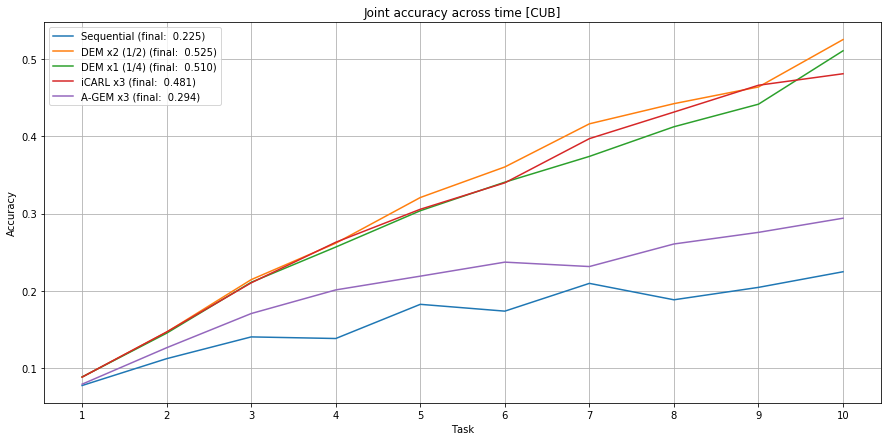

In [91]:
plt.figure(figsize=(15, 7))
plt.title(f'Joint accuracy across time [{dataset}]')

for method in methods:
    values = [(l[1:].argmax(axis=2) == t.reshape(1, -1)).mean(1) for l, t in zip(logits_histories[method], targets[method])]
    values_avg = np.array(values).mean(0)
    plt.plot(tasks, values_avg, label=f'{method} (final: {values_avg[-1]: .3f})')

# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True)
plt.legend()
plt.xlabel('Task')
plt.ylabel('Accuracy')
plt.xticks(tasks)
plt.grid()

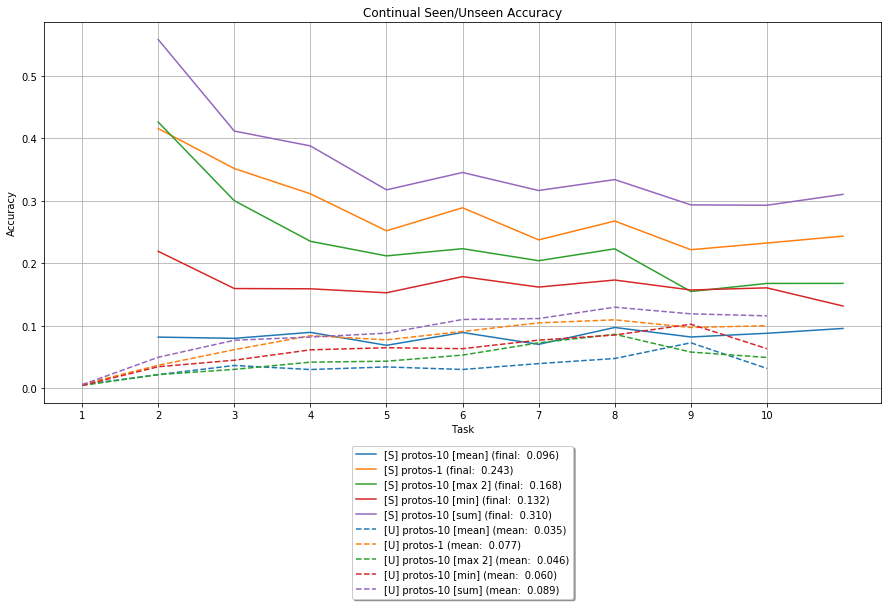

In [119]:
from matplotlib.colors import BASE_COLORS

# colors = list(BASE_COLORS.keys())
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(15, 7))
plt.title('Continual Seen/Unseen Accuracy')

for i, method in enumerate(methods):
    values = [compute_seen_classes_acc_history(l[1:], t, c, restrict_space=False) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    values_avg = np.array(values).mean(0)
    plt.plot(tasks + 1, values_avg, label=f'[S] {method} (final: {values_avg[-1]: .3f})', color=colors[i % len(colors)])
    #plt.plot(tasks, values_avg, label=f'[S] {method} (mean: {values_avg.mean(): .3f})')

for i, method in enumerate(methods):
    values = [compute_unseen_classes_acc_history(l, t, c, restrict_space=False) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    values_avg = np.array(values).mean(0)
    plt.plot(tasks, values_avg, '--', label=f'[U] {method} (mean: {values_avg.mean(): .3f})', color=colors[i % len(colors)])

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True)
plt.xlabel('Task')
plt.ylabel('Accuracy')
plt.xticks(tasks)
plt.grid()

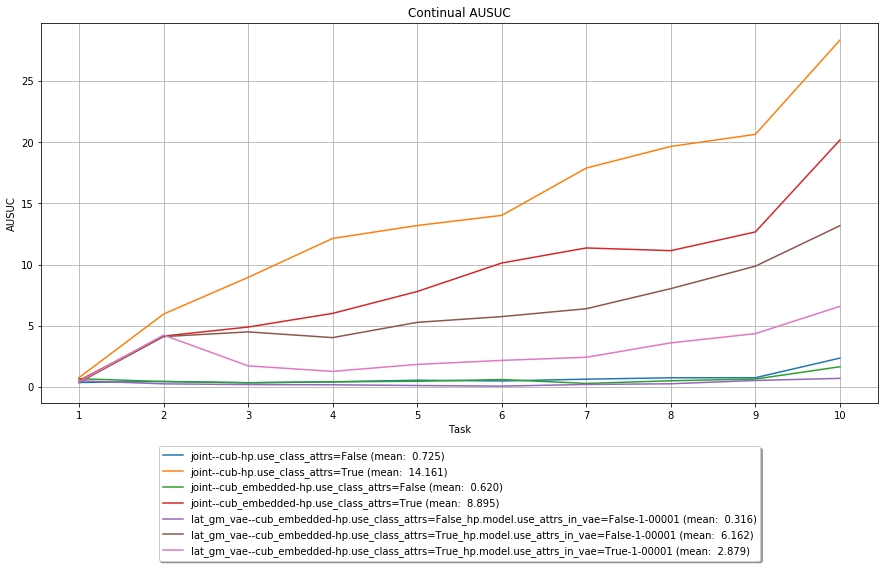

In [5]:
plt.figure(figsize=(15, 7))
plt.title('Continual AUSUC')

for method in methods:
    values = [compute_joined_ausuc_history(l, t, c) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    values_avg = np.array(values).mean(0)
    plt.plot(tasks, values_avg, label=f'{method} (mean: {values_avg.mean(): .3f})')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True)
plt.xlabel('Task')
plt.ylabel('AUSUC')
plt.xticks(tasks)
plt.grid()

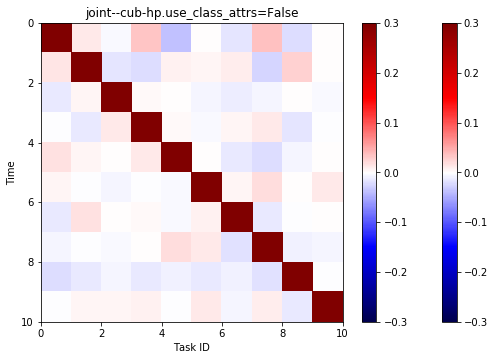

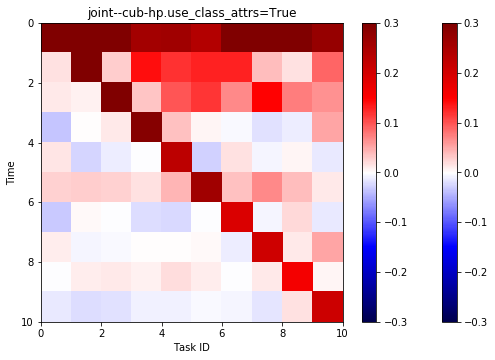

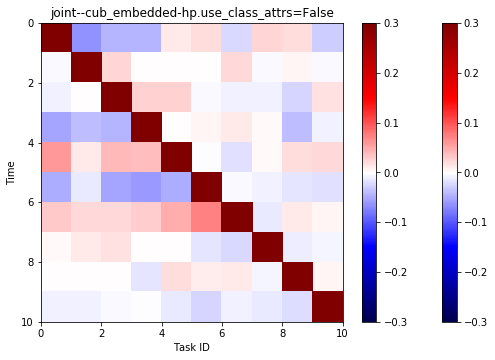

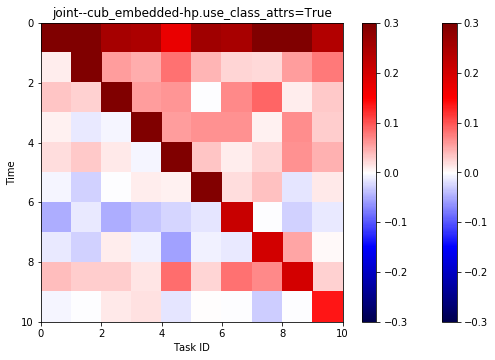

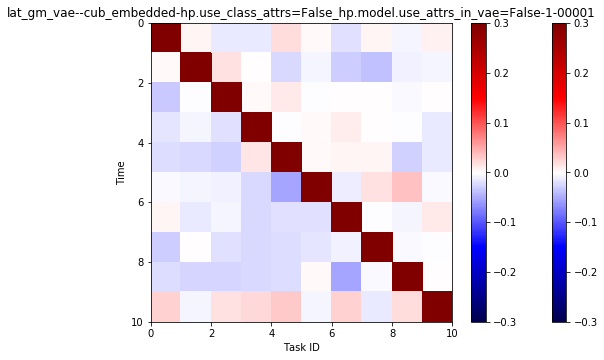

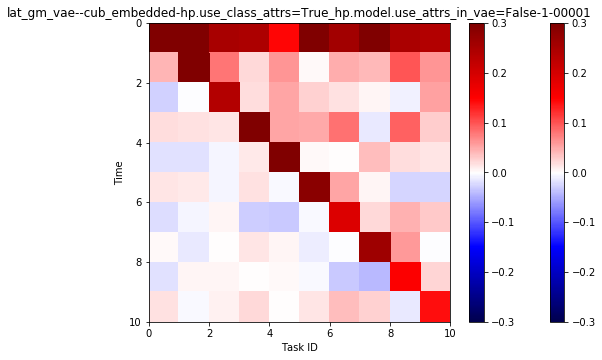

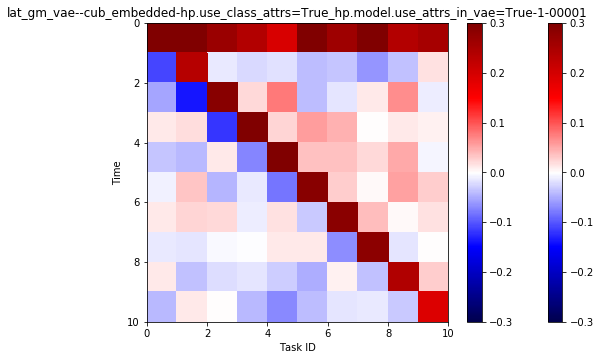

In [8]:
from tqdm import tqdm

def plot_task_transfer_matrix(values, title: str=''):
    # https://stackoverflow.com/questions/35727374/creating-a-matplotlib-heatmap-with-two-different-coloured-data-sets

    mask_red = np.triu(np.ones_like(values), k=1).astype(bool)
    mask_blue = np.tril(np.ones_like(values), k=0).astype(bool)

    values_red = np.ma.masked_where(~mask_red, values)
    values_blue = np.ma.masked_where(~mask_blue, values)

    # # Make a side-by-side plot
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.title(title)
    redmesh = ax.pcolormesh(values_red, cmap='seismic', vmin=-0.3, vmax=0.3)
    bluemesh = ax.pcolormesh(values_blue, cmap='seismic', vmin=-0.3, vmax=0.3)
    # plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.xlabel('Task ID')
    plt.ylabel('Time')

    # Add dual colorbars
    fig.subplots_adjust(bottom=0.05, right=0.78, top=0.88, wspace=0, hspace=0)
    cbar = fig.colorbar(redmesh)
    cbar = fig.colorbar(bluemesh)
    plt.show()


# plt.figure(figsize=(20, 5 * 2))

for i, method in enumerate(methods):
    values_acc = [compute_task_transfer_matrix(l, t, c) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    values_acc_avg = np.array(values_acc).mean(0)
    plot_task_transfer_matrix(values_acc_avg, method)

#     plt.subplot(3, 3, i + 1)
#     plt.title(f'Task accuracies for [{method}]')
#     plt.imshow(values_acc_avg, cmap='Blues', vmin=0, vmax=1.)
#     plt.colorbar(fraction=0.046, pad=0.04)
#     plt.ylabel('Time')
#     plt.xlabel('Which task we score')
#     plt.xticks(tasks - 1, tasks);
#     plt.yticks(tasks - 1, tasks);

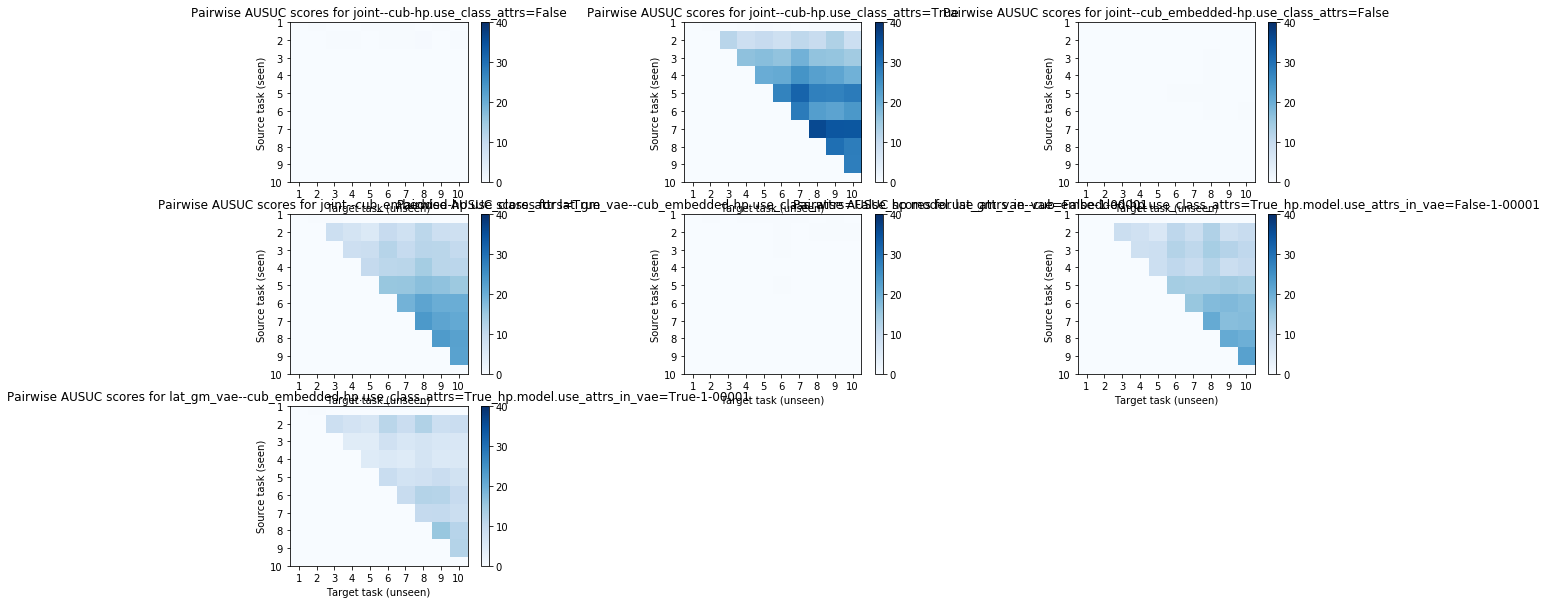

In [9]:
plt.figure(figsize=(20, 5 * 2))

for i, method in enumerate(methods):
    values_ausuc = [compute_ausuc_matrix(l[:-1], t, c) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]    
    values_ausuc_avg = np.array(values_ausuc).mean(0)
    
    plt.subplot(3, 3, i + 1)
    plt.title(f'Pairwise AUSUC scores for {method}')
    plt.imshow(np.triu(values_ausuc_avg, k=1), cmap='Blues', vmin=0, vmax=40)
    plt.colorbar(fraction=0.046, pad=0.04)
    #plt.clim(0, 100)
    plt.ylabel('Source task (seen)')
    plt.xlabel('Target task (unseen)')
    plt.xticks(tasks - 1, tasks);
    plt.yticks(tasks - 1, tasks);

In [37]:
# for method in methods:
#     values_acc = [compute_individual_accs_matrix(l[1:], t, c) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
#     values_ausuc = [compute_ausuc_matrix(l[:-1], t, c) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    
#     values_acc_avg = np.array(values_acc).mean(0)
#     values_ausuc_avg = np.array(values_ausuc).mean(0)

#     plt.figure(figsize=(15, 7))
    
#     plt.subplot(121)
#     plt.title(f'Task accuracies for [{method}]')
#     plt.imshow(values_acc_avg, cmap='Blues', vmin=0, vmax=1.)
#     plt.colorbar(fraction=0.046, pad=0.04)
#     #plt.clim(0, 1)
#     plt.ylabel('Time')
#     plt.xlabel('Which task we score')
#     plt.xticks(tasks - 1, tasks);
#     plt.yticks(tasks - 1, tasks);

#     plt.subplot(122)
#     plt.title(f'Pairwise AUSUC scores for [{method}]')
#     plt.imshow(np.triu(values_ausuc_avg), cmap='Blues', vmin=0, vmax=70)
#     plt.colorbar(fraction=0.046, pad=0.04)
#     #plt.clim(0, 100)
#     plt.ylabel('Time')
#     plt.xlabel('Which task we score')
#     plt.xticks(tasks - 1, tasks);
#     plt.yticks(tasks - 1, tasks);